##### Aprendizaje para determinar Cuerpos Celestes

#### Ocupado el Notebook DecisionTreeClassifier

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display

In [17]:
#df2 = pd.read_csv("../datos/SDSS-DR14.csv")
df2 = pd.read_csv("../datos/SDSS-DR1410_10_2024 5_41_36 AM.csv")
df2.head()

objid          ra       dec         u         g         r  \
0  1237648705131905049  224.367913  0.492218  18.30940  17.13075  16.63043   
1  1237648705131905146  224.469246  0.532670  18.22791  17.03074  16.47815   
2  1237648705131905248  224.379514  0.437444  18.55948  17.31544  16.71859   
3  1237648705131970600  224.502897  0.497601  18.55733  17.24357  16.62276   
4  1237648705131970604  224.506416  0.568373  17.54774  16.37762  15.95853   

          i         z  run  rerun  camcol  field            specobjid   class  \
0  16.43888  16.33171  752    301       5    540  3731360742641868800    STAR   
1  16.24079  16.09382  752    301       5    540  3731361567275589632    STAR   
2  16.32946  16.09309  752    301       5    540   348053737761171456  GALAXY   
3  16.34301  16.20834  752    301       5    541  3731361017519775744    STAR   
4  15.80821  15.75121  752    301       5    541  3731361842153496576    STAR   

   redshift  plate    mjd  fiberid  
0  0.000256   3314  54970      467  
1  0.000687   3314  54970      470  
2  0.083711    309  51994      548  
3 -0.000022   3314  54970      468  
4 -0.000084   3314  54970      471

In [18]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   objid      50000 non-null  int64  
 1   ra         50000 non-null  float64
 2   dec        50000 non-null  float64
 3   u          50000 non-null  float64
 4   g          50000 non-null  float64
 5   r          50000 non-null  float64
 6   i          50000 non-null  float64
 7   z          50000 non-null  float64
 8   run        50000 non-null  int64  
 9   rerun      50000 non-null  int64  
 10  camcol     50000 non-null  int64  
 11  field      50000 non-null  int64  
 12  specobjid  50000 non-null  uint64 
 13  class      50000 non-null  object 
 14  redshift   50000 non-null  float64
 15  plate      50000 non-null  int64  
 16  mjd        50000 non-null  int64  
 17  fiberid    50000 non-null  int64  
dtypes: float64(8), int64(8), object(1), uint64(1)
memory usage: 6.9+ MB


Podemos determinar que gran cantidad de datos forman parte de un formato numérico, por lo que no presentará problemas en la comparación y representación de los mismos.

In [19]:
df2.isnull().sum()

objid        0
ra           0
dec          0
u            0
g            0
r            0
i            0
z            0
run          0
rerun        0
camcol       0
field        0
specobjid    0
class        0
redshift     0
plate        0
mjd          0
fiberid      0
dtype: int64

Logramos ver ademas que basado en al dataset en su complejidad, no nos daría inconsistencias en cuanto al exceso de ruido que ésto pueda generar.

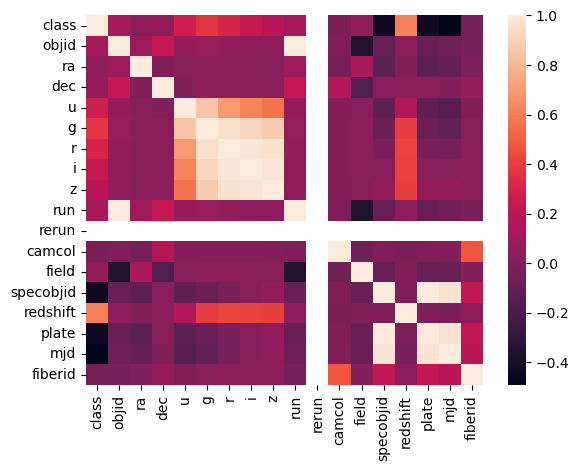

In [20]:
#código solamente para efecto práctico de mapa de calor
df2_test = df2[['class']]
df2_cp = df2
for n in range(df2_test.shape[0]):
    if df2_test.iloc[n,0] =='STAR':
        df2_test.iloc[n,0] = 1
    elif df2_test.iloc[n,0] =='GALAXY':
        df2_test.iloc[n,0] = 2
    elif df2_test.iloc[n,0] =='QSO':
        df2_test.iloc[n,0] = 3
df2_test.head()

df2_cut = df2_cp.drop(['class'],axis=1)
df2_plot = pd.concat([df2_test,df2_cut],axis=1)
#Print
sb.heatmap(df2_plot.corr())

#Restauro data
df2_data = df2

Se logra visualizar que "rerun" presenta una relación muy alta de dependencia con las demás variables, y ésto podría presentar problemas en el proceso de aprendizaje

In [21]:
df2_data = df2_data.drop(['rerun'],axis=1)

<Axes: xlabel='class', ylabel='u'>

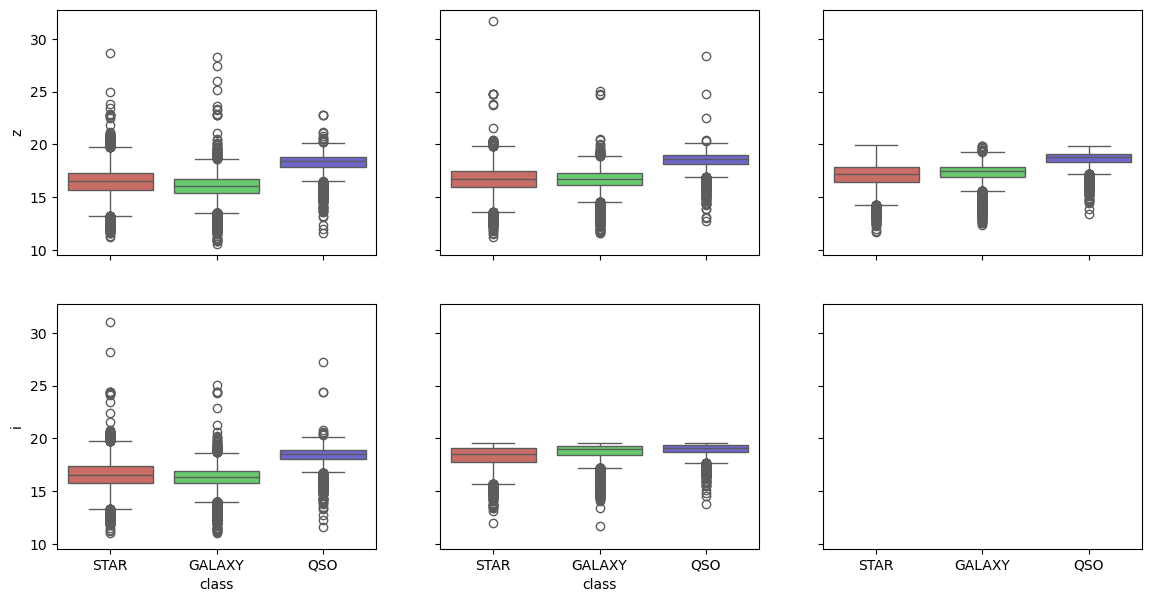

In [22]:
fig, axes = plt.subplots(2, 3,figsize=(14,7), sharex=True, sharey=True)
sb.boxplot(palette='hls', data=df2_data,x="class", y='z',ax=axes[0,0])
sb.boxplot(palette='hls', data=df2_data,x="class", y='r',ax=axes[0,1])
sb.boxplot(palette='hls', data=df2_data,x="class", y='g',ax=axes[0,2])
sb.boxplot(palette='hls', data=df2_data,x="class", y='i',ax=axes[1,0])
sb.boxplot(palette='hls', data=df2_data,x="class", y='u',ax=axes[1,1])

En estos diagramas de cajas para las propiedades de luz, las medias no se encuentran muy alejadas de sus cotas, no así sus valores extremos, por lo que podremos ver si la variabilidad nos ayuda en los procesos de clasificacion

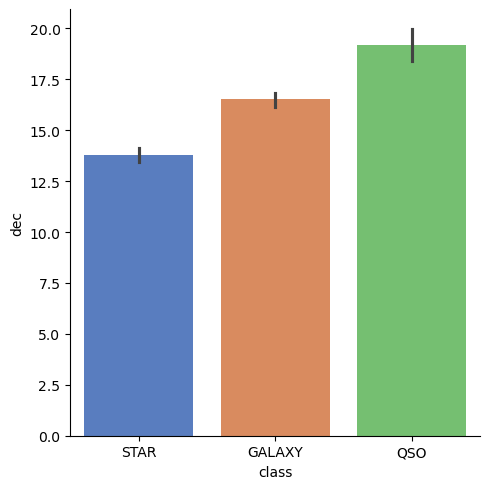

In [23]:
sb.catplot(palette='muted', kind='bar',data=df2_data,x="class", y='dec')

Con los siguientes datos, cuales presentan un grado de relación muy alto entre ellas, indicándonos una tendencia creciente sobre el objeto que se permite ver.

### Transformación de clases a variables numéricas

In [24]:
df2_data.head()

objid          ra       dec         u         g         r  \
0  1237648705131905049  224.367913  0.492218  18.30940  17.13075  16.63043   
1  1237648705131905146  224.469246  0.532670  18.22791  17.03074  16.47815   
2  1237648705131905248  224.379514  0.437444  18.55948  17.31544  16.71859   
3  1237648705131970600  224.502897  0.497601  18.55733  17.24357  16.62276   
4  1237648705131970604  224.506416  0.568373  17.54774  16.37762  15.95853   

          i         z  run  camcol  field            specobjid   class  \
0  16.43888  16.33171  752       5    540  3731360742641868800    STAR   
1  16.24079  16.09382  752       5    540  3731361567275589632    STAR   
2  16.32946  16.09309  752       5    540   348053737761171456  GALAXY   
3  16.34301  16.20834  752       5    541  3731361017519775744    STAR   
4  15.80821  15.75121  752       5    541  3731361842153496576    STAR   

   redshift  plate    mjd  fiberid  
0  0.000256   3314  54970      467  
1  0.000687   3314  54970      470  
2  0.083711    309  51994      548  
3 -0.000022   3314  54970      468  
4 -0.000084   3314  54970      471

In [25]:
df2_class = df2_data[['class']]
df2_full = df2_data.drop(['class'],axis=1)
df2_data = pd.concat([df2_class,df2_full],axis=1)

In [26]:
df2_data.head()

class                objid          ra       dec         u         g  \
0    STAR  1237648705131905049  224.367913  0.492218  18.30940  17.13075   
1    STAR  1237648705131905146  224.469246  0.532670  18.22791  17.03074   
2  GALAXY  1237648705131905248  224.379514  0.437444  18.55948  17.31544   
3    STAR  1237648705131970600  224.502897  0.497601  18.55733  17.24357   
4    STAR  1237648705131970604  224.506416  0.568373  17.54774  16.37762   

          r         i         z  run  camcol  field            specobjid  \
0  16.63043  16.43888  16.33171  752       5    540  3731360742641868800   
1  16.47815  16.24079  16.09382  752       5    540  3731361567275589632   
2  16.71859  16.32946  16.09309  752       5    540   348053737761171456   
3  16.62276  16.34301  16.20834  752       5    541  3731361017519775744   
4  15.95853  15.80821  15.75121  752       5    541  3731361842153496576   

   redshift  plate    mjd  fiberid  
0  0.000256   3314  54970      467  
1  0.000687   3314  54970      470  
2  0.083711    309  51994      548  
3 -0.000022   3314  54970      468  
4 -0.000084   3314  54970      471

### Proceso de entrenamiento y clasificación

In [27]:
X = df2_data.iloc[:,1:df2_data.shape[1]].values
y = df2_data.iloc[:,0].values

In [28]:
#Realizando Entrenamiento a 75% de acierto
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state=25)

In [29]:
from sklearn import tree
#Entrenamiento
clf = tree.DecisionTreeClassifier(ccp_alpha=0.0000007)
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
#y genera un vector de predicciones a partir de xtest

#Evaluación del rendimiento del clasificador
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
#permite comparar la test de prediccion con la prediccion real

print(confusion_matrix)
#Print de la matriz de confusión
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

[[6189   86    5]
 [  73 1172    0]
 [   4    1 4970]]
              precision    recall  f1-score   support

      GALAXY       0.99      0.99      0.99      6280
         QSO       0.93      0.94      0.94      1245
        STAR       1.00      1.00      1.00      4975

    accuracy                           0.99     12500
   macro avg       0.97      0.98      0.97     12500
weighted avg       0.99      0.99      0.99     12500



In [30]:
from six import StringIO
import pydot #sudo apt install python3-pydot graphviz

dot_data = StringIO()

features=['objid', 'ra', 'dec','u','g','r','i','z', 'run', 
          'camcol', 'field', 'specobjid', 'redshift','plate ', 'mjd', 'fiberid']
classes=['GALAXY','QSO','STAR']
tree.export_graphviz(clf,out_file=dot_data,feature_names=features,class_names=classes, filled=True, 
                     rounded=True, impurity=False)

graph = pydot.graph_from_dot_data(dot_data.getvalue())
graph[0].write_png('modelo_GLX.png')
img = Image.open('modelo_GLX.png')
display(img)